# Libraries.

In [1]:
# Essentials.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 10)

# Wordcloud.
from wordcloud import WordCloud

# Natural Language Processing.
import nltk 
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
en_stop = set(stopwords.words('english'))

import regex as re
import string as S

# Models.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
svc = SVC()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

F1_Scores = {'SVC': 0, 'Naive': 0, 'Logistic': 0}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
wnl = WordNetLemmatizer()

# !pip install contractions
import contractions
contractions.fix("I'll be there within 5 min. Shouldn't you be there too? I'd love to see u there, my dear. It's awesome to meet new friends. We've been waiting for this day for so long!")

'I will be there within 5 min. Should not you be there too? I would love to see you there, my dear. It is awesome to meet new friends. We have been waiting for this day for so long!'

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle Disaster Tweets/train.csv')

# Preprocessing Class Object.

In [4]:
class Preprocessing():

  def __init__(self, text):
    self.text = text


  # Removing newlines.
  def RemovingNewLines(self):
    if '\n' in self.text:
      self.text = self.text.replace('\n', '')
    else:
      self.text = self.text


  # Fixing contractions.
  def RemovingContractions(self):
    self.text = self.text.apply(lambda y: contractions.fix(y))


  # Replaces urlencoded characters with a white space.
  def RemovingUnicodes(self):
    if '%' in self.text:
      self.text = re.sub(r'(%\w\w)', ' ', self.text)
    else:
      self.text = self.text


  # Removing links
  def RemovingLinks(self):
    self.text = self.text.apply(lambda y: re.sub(r"http\S+", "", y))


  # Replaces the hashtag with a white space.
  def RemovingHashTags(self):
    self.text = self.text.replace('#', ' ')


  # Replaces punctuations
  def RemovingPunctuations(self):
    translator = str.maketrans(S.punctuation, ' '*len(S.punctuation))
    self.text = self.text.apply(lambda y: y.translate(translator))


  # Only retrieves words.
  def RemovingNumbers(self):
    self.text = self.text.apply(lambda y: ' '.join([wnl.lemmatize(i.lower().strip()) for i in y.split(' ') if not i.isdigit()]))


  # Replaces repeating characters.
  def RemovingRepeatingCharacters(self):
    self.text = self.text.apply(lambda y: re.sub('\*\*+', '*', y))

In [5]:
PP = Preprocessing(train['text'])

PP.RemovingNewLines()
PP.RemovingContractions()

PP.RemovingUnicodes()
PP.RemovingLinks()

PP.RemovingHashTags()
PP.RemovingPunctuations()

PP.RemovingNumbers()
PP.RemovingRepeatingCharacters()

train['cleaned_text'] = PP.text

In [6]:
train['cleaned_text']

0       our deed are the reason of this  earthquake ma...
1                  forest fire near la ronge sask  canada
2       all resident asked to  shelter in place  are b...
3       people receive  wildfire evacuation order in c...
4       just got sent this photo from ruby  alaska a s...
                              ...                        
7608    two giant crane holding a bridge collapse into...
7609     aria ahrary  thetawniest the out of control w...
7610                   m1  utc  5km s of volcano hawaii  
7611    police investigating after an e bike collided ...
7612    the latest  more home razed by northern califo...
Name: cleaned_text, Length: 7613, dtype: object

In [7]:
# Replaces empty strings with np.nan.
train['cleaned_text'] = train['cleaned_text'].apply(lambda x: x if len(x) > 0 else np.nan)

In [8]:
train.isnull().sum()

id                 0
keyword           61
location        2533
text               0
target             0
cleaned_text       0
dtype: int64

# Word Clouds.

## Negative Cases.

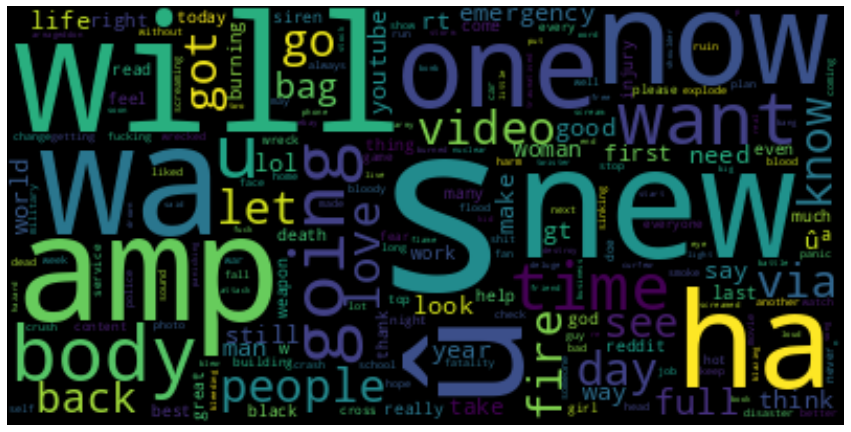

In [9]:
negative_cases = train['cleaned_text'][train['target'] == 0]
text = ' '.join(word for word in negative_cases)

word_cloud = WordCloud(collocations = False,
                       background_color = 'black').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Positive Cases.

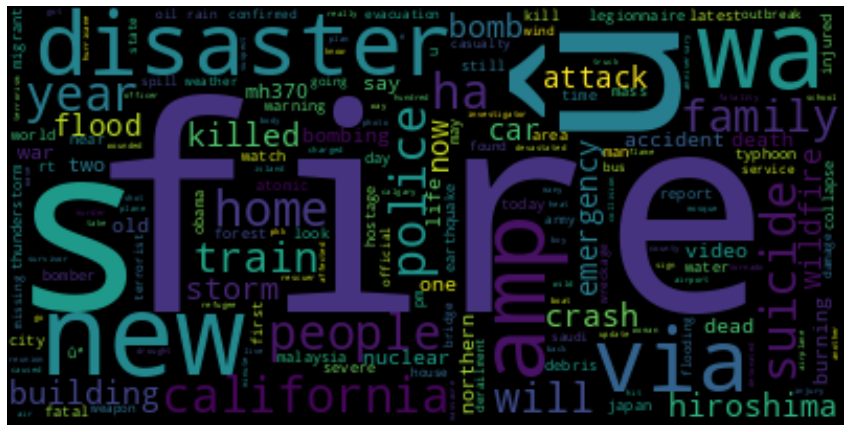

In [10]:
true_cases = train['cleaned_text'][train['target'] == 1]
text = ' '.join(word for word in true_cases)

word_cloud = WordCloud(collocations = False,
                       background_color = 'black').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
target = train['target']
train_X, val_X, train_y, val_y = train_test_split(train['cleaned_text'], target, test_size = 0.2, shuffle = True, stratify = target)

In [12]:
train_X.shape, val_X.shape

((6090,), (1523,))

# TF-IDF.

In [13]:
vectorizer = TfidfVectorizer(max_features = 5000)
vectorizer.fit(train_X)

TfidfVectorizer(max_features=5000)

In [14]:
train_X = vectorizer.transform(train_X)
val_X = vectorizer.transform(val_X)

# Support Vector Classifier.

In [15]:
svc.fit(train_X, train_y)

SVC()

## Evaluation.

In [16]:
val_pred = svc.predict(val_X)
val_cm = confusion_matrix(val_y, y_pred = val_pred)
print('Accuracy: {}'.format(accuracy_score(val_y, val_pred)))
print('F1: {}'.format(f1_score(val_y, val_pred)))

F1_Scores['SVC'] = f1_score(val_y, val_pred)

Accuracy: 0.824688115561392
F1: 0.7719897523484202


In [17]:
print(classification_report(val_y, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       869
           1       0.87      0.69      0.77       654

    accuracy                           0.82      1523
   macro avg       0.84      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



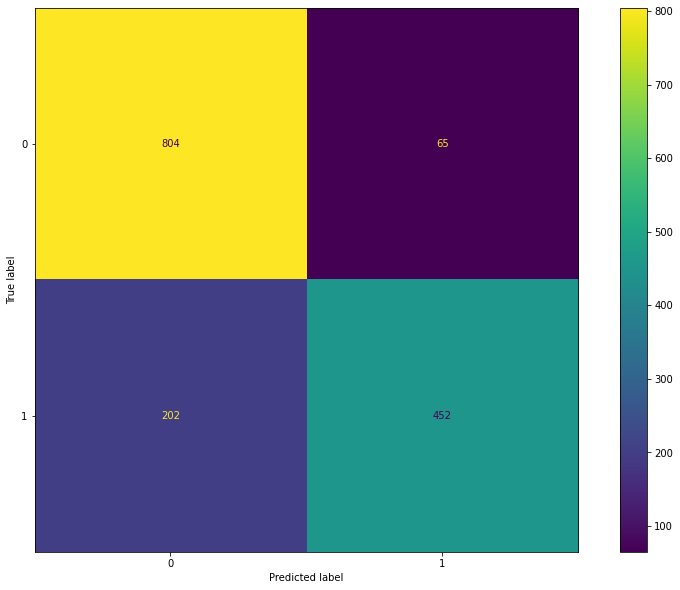

In [18]:
disp = ConfusionMatrixDisplay(val_cm)
disp.plot()
plt.show()

# Naive Bayes

In [19]:
bnb.fit(train_X, train_y)

BernoulliNB()

## Evaluation.

In [20]:
val_pred = bnb.predict(val_X)
val_cm = confusion_matrix(val_y, y_pred = val_pred)
print('Accuracy: {}'.format(accuracy_score(val_y, val_pred)))
print('F1: {}'.format(f1_score(val_y, val_pred)))

F1_Scores['Naive'] = f1_score(val_y, val_pred)

Accuracy: 0.8279711096520026
F1: 0.782392026578073


In [21]:
print(classification_report(val_y, val_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       869
           1       0.86      0.72      0.78       654

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.83      1523



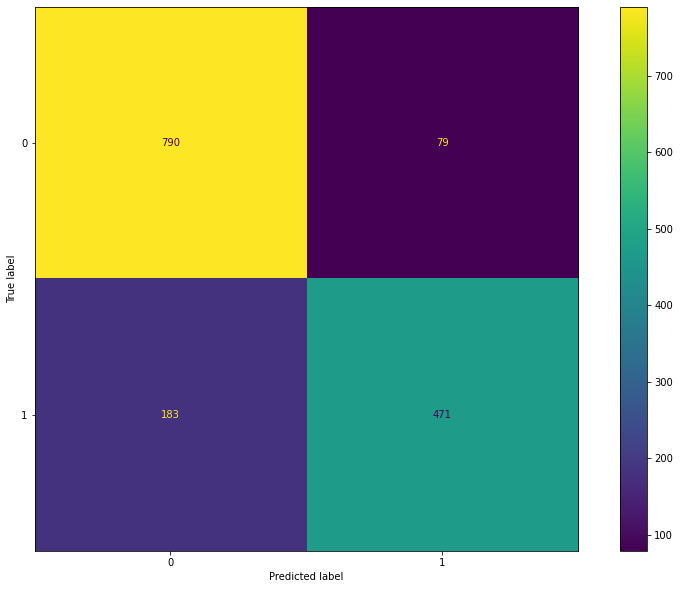

In [22]:
disp = ConfusionMatrixDisplay(val_cm)
disp.plot()
plt.show()

# Logistic Regression

In [23]:
lr.fit(train_X, train_y)

LogisticRegression()

## Evaluation.

In [24]:
val_pred = lr.predict(val_X)
val_cm = confusion_matrix(val_y, y_pred = val_pred)
print('Accuracy: {}'.format(accuracy_score(val_y, val_pred)))
print('F1: {}'.format(f1_score(val_y, val_pred)))

F1_Scores['Logistic'] = f1_score(val_y, val_pred)

Accuracy: 0.8279711096520026
F1: 0.7816666666666666


In [25]:
print(classification_report(val_y, val_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       869
           1       0.86      0.72      0.78       654

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.83      1523



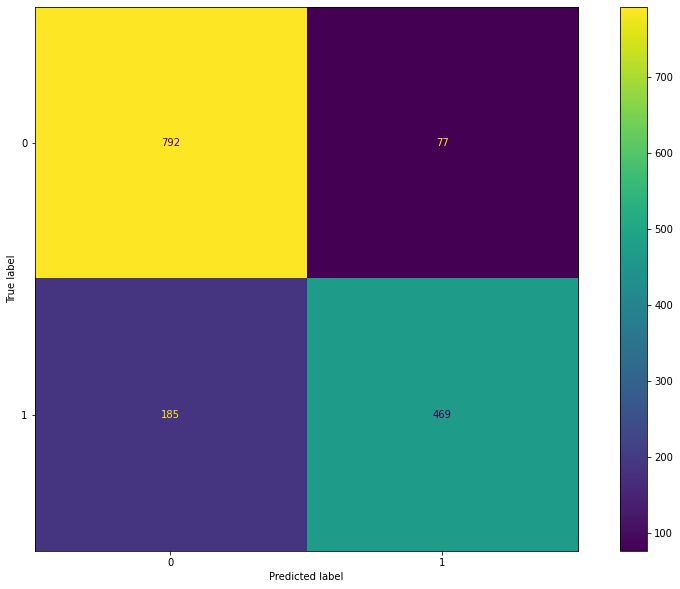

In [26]:
disp = ConfusionMatrixDisplay(val_cm)
disp.plot()
plt.show()

In [27]:
F1_Scores

{'SVC': 0.7719897523484202,
 'Naive': 0.782392026578073,
 'Logistic': 0.7816666666666666}

# Test Predictions.

In [28]:
test = pd.read_csv('/content/drive/MyDrive/Kaggle Disaster Tweets/test.csv')

In [29]:
PP = Preprocessing(test['text'])

PP.RemovingNewLines()
PP.RemovingContractions()

PP.RemovingUnicodes()
PP.RemovingLinks()

PP.RemovingHashTags()
PP.RemovingPunctuations()

PP.RemovingNumbers()
PP.RemovingRepeatingCharacters()

In [30]:
test['cleaned_text'] = PP.text

# Replaces empty strings with np.nan.
test['cleaned_text'] = test['cleaned_text'].apply(lambda x: x if len(x) > 0 else np.nan)

In [31]:
test.isnull().sum()

id                 0
keyword           26
location        1105
text               0
cleaned_text       0
dtype: int64

In [32]:
test_X = vectorizer.transform(test['cleaned_text'])

In [35]:
svc_submission = test[['id']]
svc_submission['target'] = svc.predict(test_X)
svc_submission.to_csv('svc_submission.csv', index = False)

<ipython-input-35-0e2065175204>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svc_submission['target'] = svc.predict(test_X)


In [37]:
bnb_submission = test[['id']]
bnb_submission['target'] = bnb.predict(test_X)
bnb_submission.to_csv('bnb_submission.csv', index = False)

<ipython-input-37-6831771af9c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnb_submission['target'] = bnb.predict(test_X)


In [36]:
lr_submission = test[['id']]
lr_submission['target'] = lr.predict(test_X)
lr_submission.to_csv('lr_submission.csv', index = False)

<ipython-input-36-d51de5141d14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_submission['target'] = lr.predict(test_X)
